In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing import image
from pathlib import Path
import pandas as pd

In [53]:
p=Path("./POKE DEX SVM/Images")
img_data=[]
imageId=pd.read_csv("./POKE DEX SVM/train.csv").values[:,0]
for img in imageId:
    img = image.load_img(str(p)+'/'+img, target_size =(32, 32))
    img_data.append(image.img_to_array(img))    



In [54]:
print(len(img_data))

img_data=np.array(img_data)/255.0
#print(img_data)


304


In [55]:


labels=pd.read_csv("./POKE DEX SVM/train.csv").values[:,-1]
labels=np.array(labels)

labels[labels=='Pikachu'] = 0
labels[labels=='Bulbasaur'] = 1
labels[labels=='Charmander'] = 2
print(len(labels))

304


In [56]:
import random
combined=list(zip(img_data,labels))
random.shuffle(combined)
img_data[:],labels[:]=zip(*combined)

In [57]:
def drawimages(image):
    plt.imshow(image)
    plt.show()
    return
    

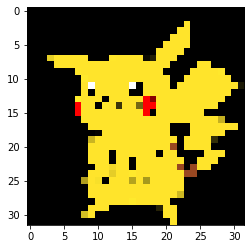

In [58]:
drawimages(img_data[0])

In [59]:
samples = img_data.shape[0]
img_data = img_data.reshape((samples, -1))

In [60]:

print(img_data.shape)
print(labels.shape)
print(type(labels))

(304, 3072)
(304,)
<class 'numpy.ndarray'>


In [61]:
class SVM:
    def __init__(self,C):
        self.w=0
        self.b=0
        self.C=C
    def hingeloss(self,x,y,w,b):
        loss=0.0
        loss+=0.5 * np.dot(w,w.T)
        m=x.shape[0]
        for i in range(m):
            ti=y[i]*(np.dot(w,x[i].T)+b)
            loss+=self.C*max(0,(1-ti))
        return loss[0][0]
    def fit(self,x,y,learning_rate=0.000001,batch_size=100,max_steps=1000):
        m,n=x.shape
        w=np.zeros((1,n))
        b=0
        losses=[]
        for i in range(max_steps):
            l=self.hingeloss(x,y,w,b)
            losses.append(l)
            
            ids=np.arange(m)
            np.random.shuffle(ids)
            
            for batch_start in range(0,m):
                gradw=0
                gradb=0
                for j in range(batch_start,batch_start+batch_size):
                    if j<m:
                        i=ids[j]
                        ti=y[i]*(np.dot(w,x[i].T)+b)
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw+=self.C*y[i]*x[i]
                            gradb+=self.C*y[i]
                w=w-learning_rate * w + learning_rate * gradw
                b=b+learning_rate * gradb
        self.b=b
        self.w=w
        return w,b,losses
        

In [62]:
#myself=SVM(C=1.0)

#w,b,loss=myself.fit(img_data,labels)
#print(w,b)


In [63]:
classes=len(np.unique(labels))
print(classes)

3


In [64]:
def class_wise_data(x,y):
    data = {}
    
    for i in range(classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

    

In [65]:
data=class_wise_data(img_data,labels)
#print(data)

    

In [66]:
def getDataPairsFromSVM(d1,d2):
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    data_pairs=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    data_pairs[:l1,:]=d1
    data_pairs[l1:,:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=1
    return data_pairs,data_labels
def trainSVMs(x,y):
    svm_classifiers={}
    for i in range(classes):
        svm_classifiers[i]={}
        for j in range(i+1,classes):
            xi,yi=getDataPairsFromSVM(data[i],data[j])
            wts,b,loss=myself.fit(xi,yi)
            svm_classifiers[i][j]=(wts,b)
            plt.plot(loss)
            plt.show()
    return svm_classifiers 

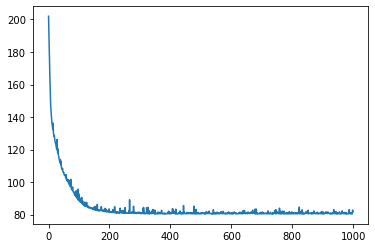

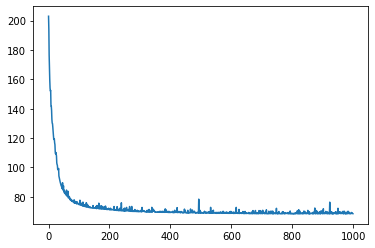

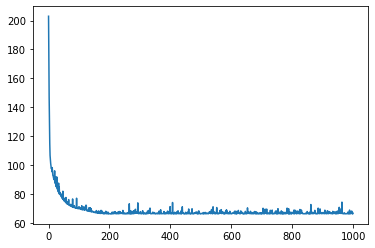

In [67]:
mySVM=SVM(C=5.0)
svm_classifiers = trainSVMs(img_data,labels)
#print(svm_classifiers)

In [68]:
def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1
def predict(x):
    count=np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b=svm_classifiers[i][j]
            z=binaryPredict(x,w,b)
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
    final_pred=np.argmax(count)
    return final_pred

In [69]:
p=Path("./POKE DEX SVM/Images")
img_data_test=[]
imageId=pd.read_csv("./POKE DEX SVM/test.csv").values[:,0]

#print(imageId)
for imgtest in imageId:
    imgtest = image.load_img(str(p)+'/'+imgtest, target_size =(32, 32))
    img_data_test.append(image.img_to_array(imgtest))    

print(len(img_data_test))
img_data_test=np.array(img_data_test)/255.0   
samplestest=img_data_test.shape[0]
img_data_test=img_data_test.reshape((samplestest,-1))
    

123


In [70]:
ytest=[predict(i) for i in img_data_test]
ytestnew=[]
for i in ytest:
    if i==0:
        ytestnew.append("Pikachu")
    if i==1:
        ytestnew.append("Bulbasaur")
    if i==2:
        ytestnew.append("Charmander")
ytestnew=np.array(ytestnew)
final=np.column_stack((imageId,ytestnew))
df=pd.DataFrame(final,columns=['ImageId','NameOfPokemon'])
df.head()
df.to_csv('pokedexoutput.csv',index=False)
